# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   https://www.kaggle.com/datasets/rezkyyayang/pekerja-sejahtera

   `gk.df.csv`: dataset **Garis Kemiskinan Per Kapita** dengan disagregasi Provinsi, Tahun, Periode Survei, Jenis Pengeluaran, dan Daerah Tempat Tinggal.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from google.colab import drive

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [6]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/data/gk.df.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

1. **Memahami Struktur Data**  
Dataset ini memiliki **5.460 baris** dan **6 kolom** dengan tipe data sebagai berikut:  
  - **provinsi** (kategorikal) - Nama provinsi di Indonesia.  
  - **jenis** (kategorikal) - Jenis bantuan yang diterima (MAKANAN, NONMAKANAN, TOTAL).  
  - **daerah** (kategorikal) - Nama daerah atau wilayah (PERDESAAN, PERKOTAAN, PERDESAANPERKOTAAN).  
  - **tahun** (numerikal) - Tahun pengambilan data (2013 - 2022).  
  - **periode** (kategorikal) - Periode penerimaan bantuan (MARET, SEPTEMBER).  
  - **gk** (numerikal) - Angka garis kemiskinan.  

In [7]:
print("Rows n Columns:")
print(df.shape)

print("\nDataset Information:")
print(df.info())

Rows n Columns:
(5460, 6)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  5460 non-null   object 
 1   jenis     5460 non-null   object 
 2   daerah    5460 non-null   object 
 3   tahun     5460 non-null   int64  
 4   periode   5460 non-null   object 
 5   gk        5261 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 256.1+ KB
None


2. **Menangani Data yang Hilang**  
  - **Kolom gk** memiliki **199 nilai yang hilang**.  
  - Tidak ditemukan nilai yang hilang pada kolom lainnya.  
  - Langkah penanganan:  
    - **Opsi 1**: Menghapus baris dengan nilai hilang jika jumlahnya kecil dan tidak signifikan.  
    - **Opsi 2**: Mengisi nilai hilang dengan metode seperti *mean*, *median*, atau interpolasi jika memungkinkan.  


In [8]:
print("Missing Data:")
print(df.isnull().sum())

print("\nDuplicate:")
print(df.duplicated().sum())

Missing Data:
provinsi      0
jenis         0
daerah        0
tahun         0
periode       0
gk          199
dtype: int64

Duplicate:
0


3. **Analisis Distribusi dan Korelasi**  
   - **Fitur `tahun`**
    - Data tersebar antara tahun **2013 hingga 2022** dengan nilai rata-rata di sekitar **2018**.
    - Histogram menunjukkan distribusi yang relatif merata dengan jumlah data yang meningkat pada tahun-tahun terakhir.
    - Boxplot mengindikasikan bahwa tidak terdapat *outlier* pada fitur ini.

   - **Fitur `gk`**
    - Nilai berkisar antara **48.561 hingga 872.843**, dengan rata-rata sekitar **303.904**.
    - Histogram menunjukkan distribusi yang **condong ke kanan (*skewed right*)**, yang berarti sebagian besar data memiliki nilai lebih rendah, sedangkan ada beberapa nilai yang sangat besar.
    - Boxplot menunjukkan adanya **beberapa *outlier*** di bagian atas, yang menunjukkan keberadaan data dengan nilai sangat tinggi dibandingkan lainnya.
   
   - **Korelasi Antar Variabel**
    - Korelasi antara `tahun` dan `gk` adalah **0.23**, yang menunjukkan **hubungan positif lemah** antara keduanya.
    - Artinya, semakin baru tahun, ada kecenderungan nilai `gk` meningkat, tetapi hubungan ini tidak terlalu kuat.
    - Dari heatmap, terlihat bahwa tidak ada korelasi kuat antara kedua variabel ini.

In [9]:
print("\nStatistics:")
print(df.describe())


Statistics:
             tahun             gk
count  5460.000000    5261.000000
mean   2018.115385  303904.185516
std       2.577159  158176.024903
min    2013.000000   48561.000000
25%    2016.000000  144674.000000
50%    2018.000000  313294.000000
75%    2020.000000  410188.000000
max    2022.000000  872843.000000


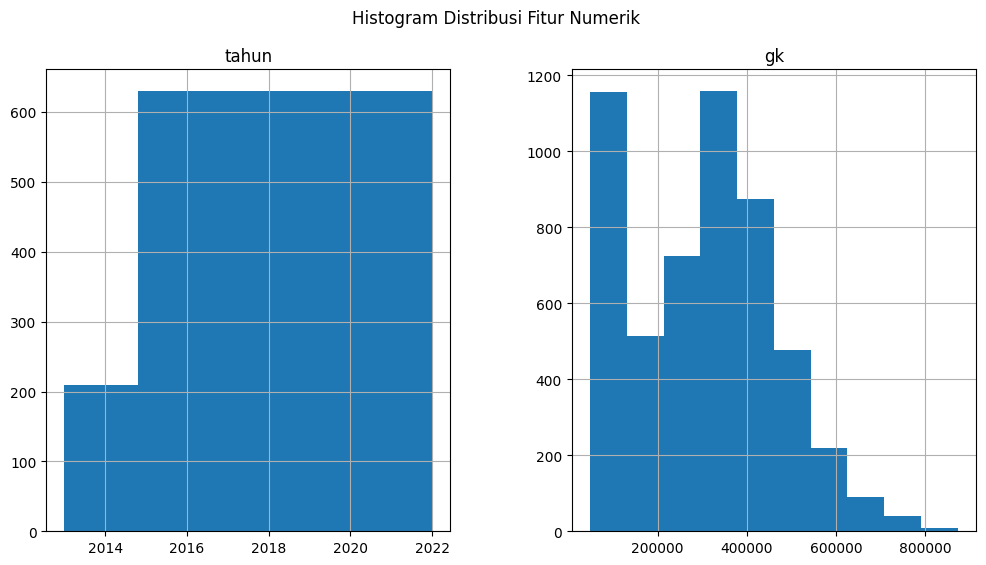

In [10]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df[numeric_features].hist(figsize=(12, 6))
plt.suptitle("Histogram Distribusi Fitur Numerik")
plt.show()

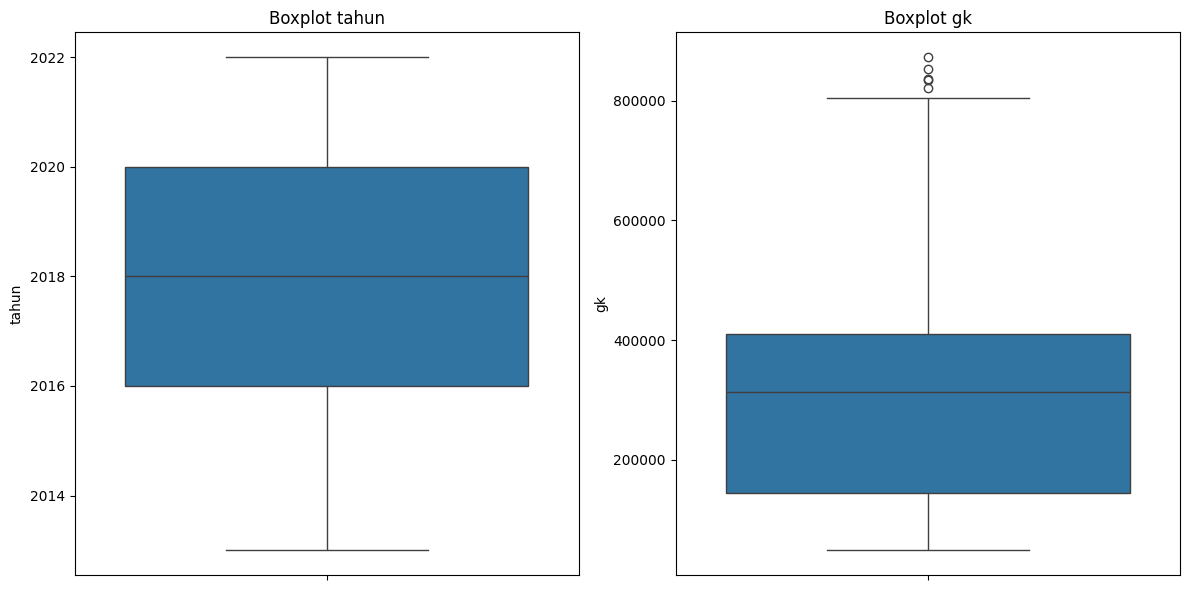

In [11]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

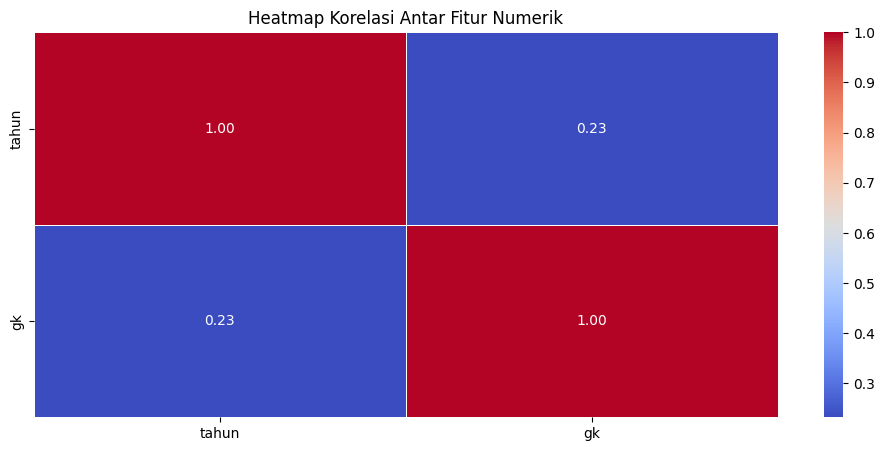

In [12]:
plt.figure(figsize=(12, 5))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.show()

4. **Visualisasi Data**  
   - **Fitur `Provinsi`**
    - Grafik batang menunjukkan bahwa distribusi data di setiap provinsi **sama rata**, dengan jumlah **156** untuk masing-masing provinsi.
    - Tidak ada provinsi yang mendominasi atau memiliki jumlah data yang lebih banyak dibanding yang lain.

   - **Fitur `jenis`**
    - jenis TOTAL memiliki jumlah data paling banyak, dengan angka lebih dari **2000+**.
    - Jenis lain memiliki jumlah yang lebih sedikit dibandingkan dengan kategori TOTAL.

  - **Fitur `Daerah`**
    - Distribusi data di setiap daerah juga **sama rata**.
    - Tidak ada daerah yang lebih dominan dalam jumlah data dibandingkan daerah lain.

  - **Fitur `Periode`**
    - Periode **Maret-September** memiliki jumlah data yang sama rata, tanpa ada periode tertentu yang mendominasi.

   - **Korelasi Antar Variabel**
    - Nilai korelasi antar variabel tidak ada atau nol, sehingga masing-masing variabel dianggap tidak memiliki keterkaitan satu sama lain.

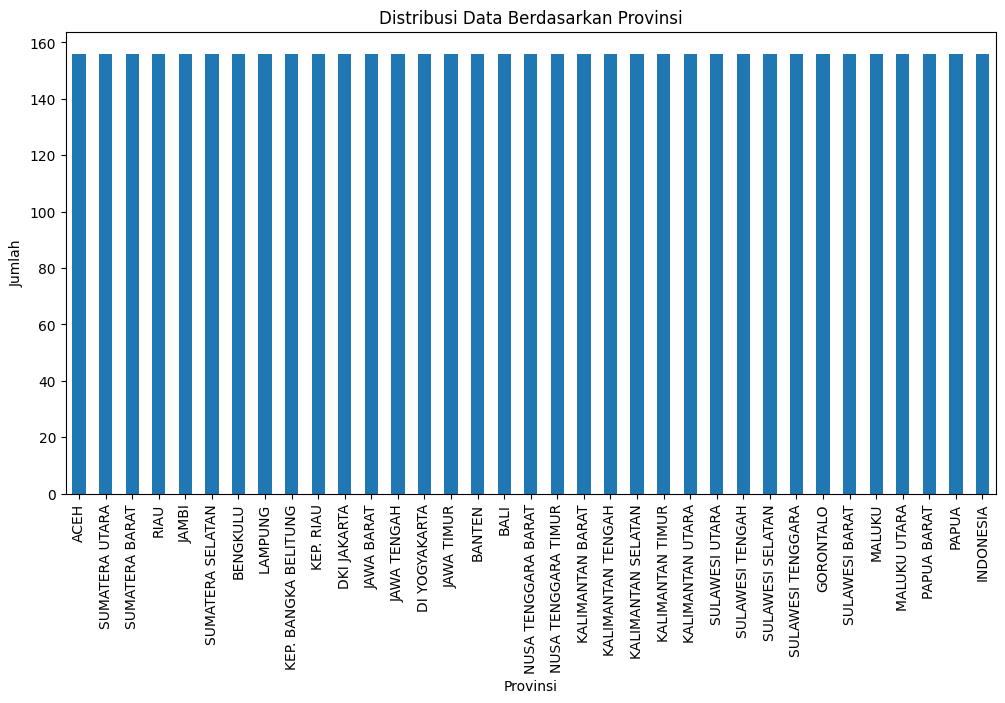

In [13]:
df["provinsi"].value_counts().plot(kind="bar", figsize=(12, 6))

plt.title("Distribusi Data Berdasarkan Provinsi")
plt.xlabel("Provinsi")
plt.ylabel("Jumlah")
plt.show()

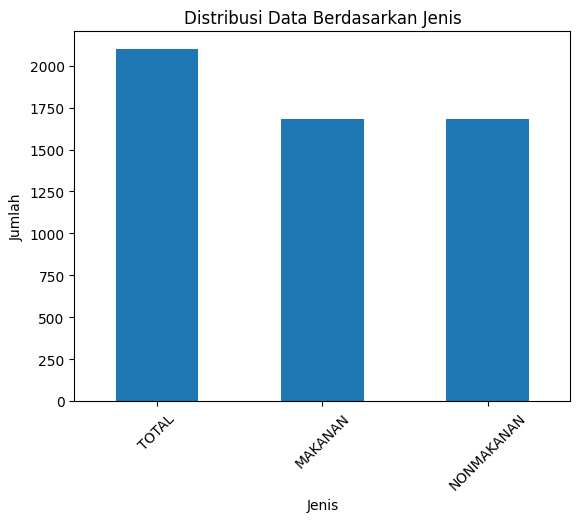

In [14]:
df["jenis"].value_counts().plot(kind="bar")

plt.title("Distribusi Data Berdasarkan Jenis")
plt.xlabel("Jenis")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()

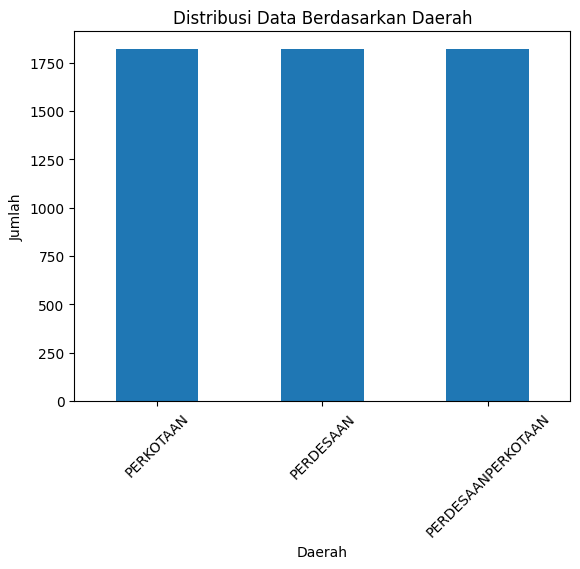

In [15]:
df["daerah"].value_counts().plot(kind="bar")
plt.title("Distribusi Data Berdasarkan Daerah")
plt.xlabel("Daerah")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()

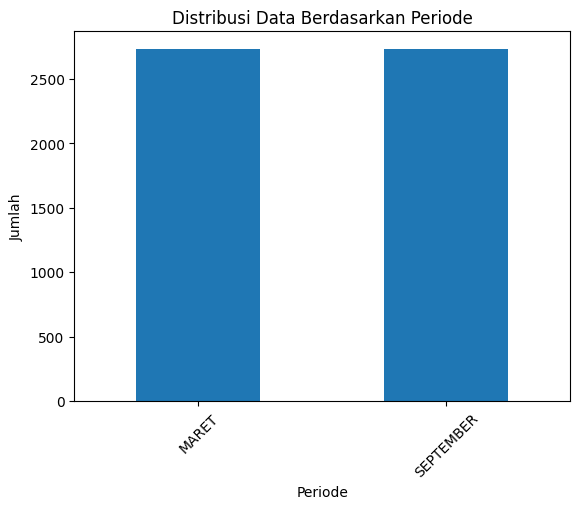

In [16]:
df["periode"].value_counts().plot(kind="bar")
plt.title("Distribusi Data Berdasarkan Periode")
plt.xlabel("Periode")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()

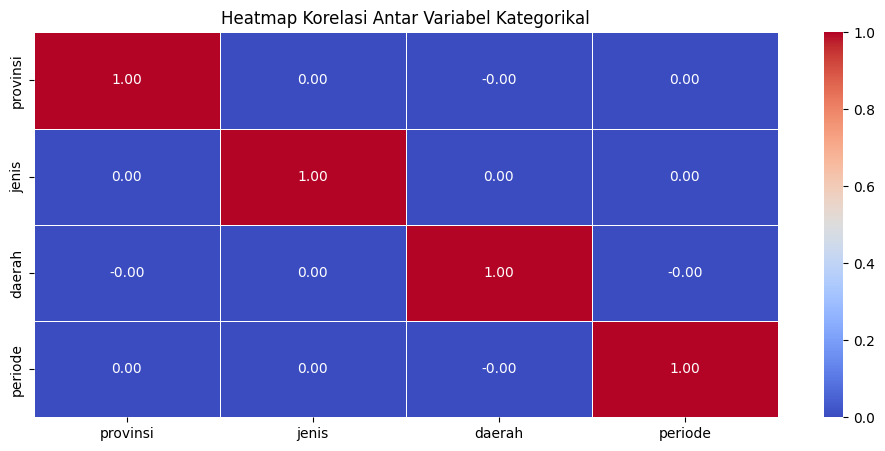

In [17]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

df_encoded = df[categorical_features].apply(lambda col: LabelEncoder().fit_transform(col))

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Kategorikal")
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

1. Menghapus atau Menangani Data Kosong (Missing Values)
   - **Fitur `Numerik`** diisi dengan median untuk menjaga kestabilan terhadap outlier
   - **Fitur `Kategorikal`** diisi dengan modus untuk mempertahankan nilai representatif

In [18]:
df[numeric_features] = df[numeric_features].apply(lambda x: x.fillna(x.median()))
df[categorical_features] = df[categorical_features].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [19]:
print("Missing Data:")
print(df.isnull().sum())

Missing Data:
provinsi    0
jenis       0
daerah      0
tahun       0
periode     0
gk          0
dtype: int64


2. Standarisasi Fitur **`Numerik`** & Encoding Fitur **`Kategorikal`**

In [20]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

processed_data = preprocessor.fit_transform(df)

3. Deteksi dan Penanganan Outlier Fitur **`Numerik`**  

In [21]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso_forest.fit_predict(df[numeric_features])

df = df[outlier_preds == 1]

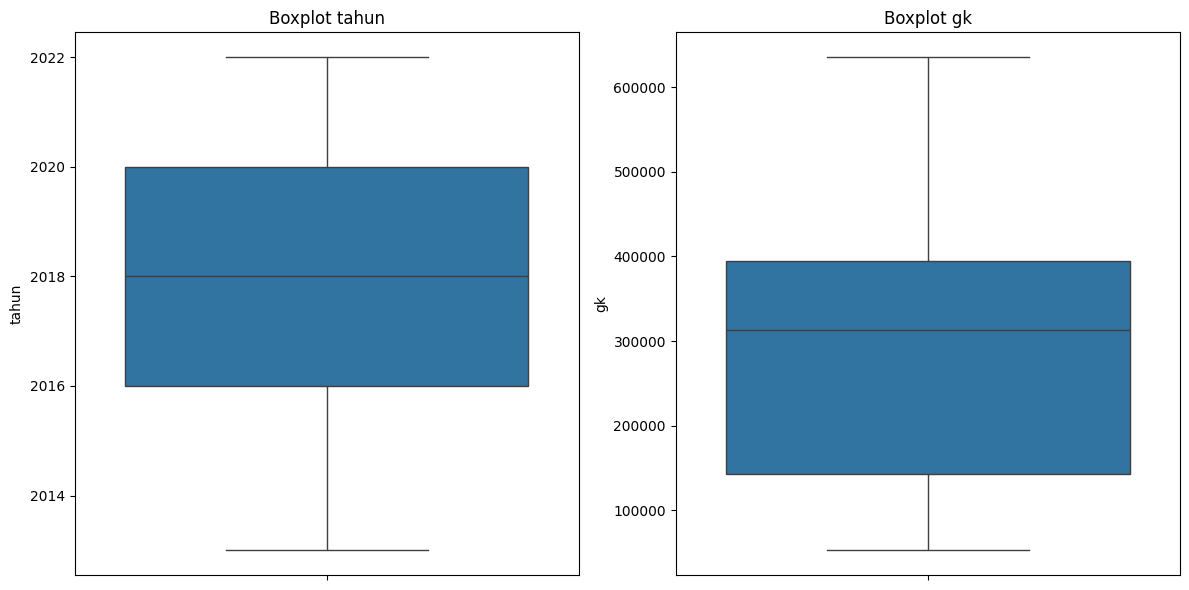

In [22]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Menggunakan **Elbow Method** untuk menentukan jumlah cluster optimal.
2. Latih **model K-Means** dengan jumlah cluster berdasarkan hasil **Elbow Method**.

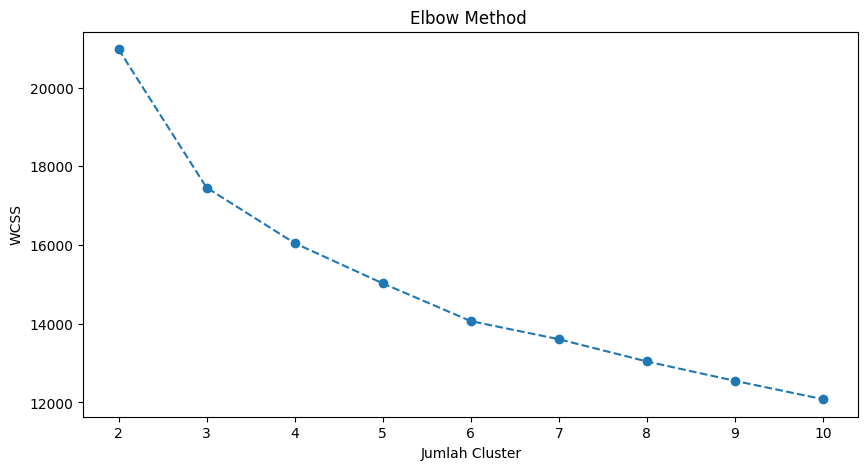

In [23]:
X = processed_data

wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method ')
plt.show()

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan **Elbow Method** dan **Silhouette Score** untuk menentukan jumlah cluster optimal.

In [24]:
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X)
labels = kmeans.labels_

In [25]:
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.19532300837975738


Dari hasil Silhouette Score, nilai tertinggi diperoleh pada **`k=2 (0.196)`**. Ini menunjukkan bahwa pemisahan antar-cluster terbaik terjadi saat menggunakan 2 cluster. Namun, karena **Elbow Method** tidak menunjukkan titik siku yang jelas, keputusan akhir sebaiknya mempertimbangkan interpretasi bisnis dan karakteristik data. Jika dua cluster tidak cukup representatif, bisa dipertimbangkan **`k=3 (0.189)`**.

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

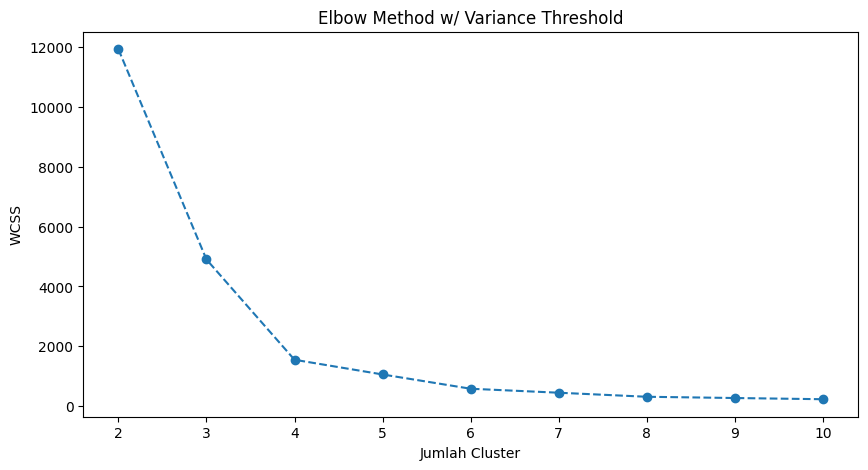

In [26]:
processed_data = preprocessor.transform(df)

scaler = StandardScaler()
processed_data_scaled = scaler.fit_transform(processed_data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(processed_data_scaled)

slt = VarianceThreshold(threshold=0.5)
X_thr = slt.fit_transform(X_pca)

wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_thr)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method w/ Variance Threshold')
plt.show()

In [37]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_thr)
labels = kmeans.labels_

In [38]:
silhouette_avg = silhouette_score(X_thr, labels)
print(f'Silhouette Score w/ Variance Threshold: {silhouette_avg}')

Silhouette Score w/ Variance Threshold: 0.7810185414858981


In [29]:
best_score_X = -1
best_clusters_X = 0

print("=== Perhitungan Silhouette Score untuk X ===")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)

    print(f"Silhouette Score untuk {k} cluster: {score:.4f}")

    if score > best_score_X:
        best_score_X = score
        best_clusters_X = k

print(f"\nOptimal jumlah cluster untuk X: {best_clusters_X} dengan Silhouette Score: {best_score_X:.4f}\n")

=== Perhitungan Silhouette Score untuk X ===
Silhouette Score untuk 2 cluster: 0.1953
Silhouette Score untuk 3 cluster: 0.1941
Silhouette Score untuk 4 cluster: 0.1779
Silhouette Score untuk 5 cluster: 0.1586
Silhouette Score untuk 6 cluster: 0.1548
Silhouette Score untuk 7 cluster: 0.1488
Silhouette Score untuk 8 cluster: 0.1468
Silhouette Score untuk 9 cluster: 0.1432
Silhouette Score untuk 10 cluster: 0.1503

Optimal jumlah cluster untuk X: 2 dengan Silhouette Score: 0.1953



In [30]:
best_score_X_thr = -1
best_clusters_X_thr = 0

print("=== Perhitungan Silhouette Score untuk X_thr ===")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_thr)
    score = silhouette_score(X_thr, labels)

    print(f"Silhouette Score untuk {k} cluster: {score:.4f}")

    if score > best_score_X_thr:
        best_score_X_thr = score
        best_clusters_X_thr = k

print(f"\nOptimal jumlah cluster untuk X_thr: {best_clusters_X_thr} dengan Silhouette Score: {best_score_X_thr:.4f}")

=== Perhitungan Silhouette Score untuk X_thr ===
Silhouette Score untuk 2 cluster: 0.5065
Silhouette Score untuk 3 cluster: 0.6639
Silhouette Score untuk 4 cluster: 0.7810
Silhouette Score untuk 5 cluster: 0.7215
Silhouette Score untuk 6 cluster: 0.6643
Silhouette Score untuk 7 cluster: 0.6657
Silhouette Score untuk 8 cluster: 0.6662
Silhouette Score untuk 9 cluster: 0.6550
Silhouette Score untuk 10 cluster: 0.6429

Optimal jumlah cluster untuk X_thr: 4 dengan Silhouette Score: 0.7810


Dari hasil perhitungan di atas, terlihat bahwa **X (data asli)** memiliki jumlah cluster optimal 2 dengan **`Silhouette Score = 0.1953`** (cukup rendah, menunjukkan pemisahan cluster kurang baik). **X_thr (data setelah thresholding/feature engineering)** memiliki jumlah cluster optimal 4 dengan **`Silhouette Score = 0.7810`** (sangat baik, menunjukkan pemisahan cluster yang lebih jelas).

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

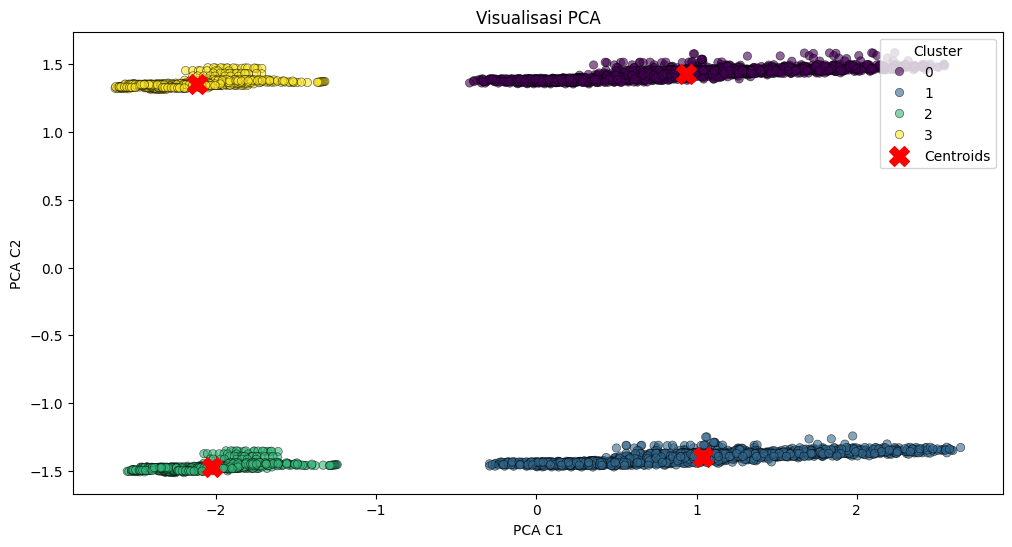

In [39]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_thr)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels,
                palette="viridis", alpha=0.6, edgecolor="k")

if 'kmeans' in locals():
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X',
                s=200, c='red', label='Centroids')

plt.xlabel("PCA C1")
plt.ylabel("PCA C2")
plt.title("Visualisasi PCA")

plt.legend(title="Cluster", loc="upper right")

plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

In [40]:
df.loc[:, 'Cluster'] = kmeans.labels_

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [41]:
categorical_encoder = preprocessor.named_transformers_['cat']

categorical_encoded = processed_data[:, len(numeric_features):]

df[categorical_features] = categorical_encoder.inverse_transform(categorical_encoded)

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [42]:
numeric_encoder = preprocessor.named_transformers_['num']

numeric_encoded = processed_data[:, :len(numeric_features)]

df[numeric_features] = numeric_encoder.inverse_transform(numeric_encoded)

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [43]:
numeric_agg = df[numeric_features + ['Cluster']].groupby('Cluster').agg(['min', 'max', 'mean'])

categorical_agg = df[categorical_features + ['Cluster']].groupby('Cluster').agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([numeric_agg, categorical_agg], axis=1)

print(cluster_summary)

         (tahun, min)  (tahun, max)  (tahun, mean)  (gk, min)  (gk, max)  \
Cluster                                                                    
0              2013.0        2022.0    2017.974562   181842.0   634703.0   
1              2013.0        2022.0    2017.950057   186893.0   635539.0   
2              2015.0        2022.0    2018.504172    52745.0   313294.0   
3              2015.0        2022.0    2018.508353    52529.0   313294.0   

            (gk, mean)            provinsi       jenis              daerah  \
Cluster                                                                      
0        369476.358395  KALIMANTAN SELATAN       TOTAL  PERDESAANPERKOTAAN   
1        377005.442595              BANTEN       TOTAL  PERDESAANPERKOTAAN   
2        121735.493445                ACEH  NONMAKANAN  PERDESAANPERKOTAAN   
3        117695.318616                ACEH  NONMAKANAN  PERDESAANPERKOTAAN   

           periode  
Cluster             
0            MARET  
1        SE

## **Analisis Klaster Garis Kemiskinan Per Kapita**

### **Klaster 0 (Biru Tua)**
- **Variabel Target**: Garis Kemiskinan Per Kapita (GK)
- **Variabel 1**: Tahun
  - **Nilai rata-rata**: 2017.97
  - **Batas minimum**: 2013
  - **Batas maksimum**: 2022
- **Variabel 2**: GK (Garis Kemiskinan Per Kapita)
  - **Nilai rata-rata**: 369476.36
  - **Batas minimum**: 181842
  - **Batas maksimum**: 634703
- **Variabel 3**: Provinsi
  - **Nilai modus kategori**: Kalimantan Selatan
- **Variabel 4**: Jenis Pengeluaran
  - **Nilai modus kategori**: TOTAL
- **Variabel 5**: Daerah Tempat Tinggal
  - **Nilai modus kategori**: PERDESAANPERKOTAAN
- **Variabel 6**: Periode Survei
  - **Nilai modus kategori**: MARET
- **Analisis**: Cluster ini merepresentasikan pola pengeluaran di Kalimantan Selatan untuk seluruh kategori konsumsi (baik makanan maupun nonmakanan) pada periode Maret. Dengan rentang waktu data dari 2013 hingga 2022, rata-rata pengeluaran masyarakat berada di angka 369,476.36 dengan variasi yang cukup tinggi. Hal ini mengindikasikan bahwa terdapat perbedaan cukup besar antara individu atau kelompok dengan tingkat konsumsi yang lebih tinggi dan lebih rendah Pengeluaran minimum yang cukup besar (181,842) menunjukkan bahwa bahkan individu atau kelompok dengan konsumsi paling rendah masih memiliki tingkat pengeluaran yang cukup signifikan. Sebaliknya, angka maksimum mencapai lebih dari 600 ribu, yang menunjukkan adanya segmen masyarakat dengan daya beli yang sangat tinggi. Hal ini bisa dikaitkan dengan perkembangan ekonomi di daerah tersebut, di mana terdapat kelompok yang memiliki akses terhadap pendapatan lebih besar dan cenderung membelanjakan uang dalam jumlah lebih tinggi.

---

### **Klaster 1 (Ungu Tua)**
- **Variabel Target**: Garis Kemiskinan Per Kapita (GK)
- **Variabel 1**: Tahun
  - **Nilai rata-rata**: 2017.95
  - **Batas minimum**: 2013
  - **Batas maksimum**: 2022
- **Variabel 2**: GK (Garis Kemiskinan Per Kapita)
  - **Nilai rata-rata**: 377005.44
  - **Batas minimum**: 186893
  - **Batas maksimum**: 635539
- **Variabel 3**: Provinsi
  - **Nilai modus kategori**: Banten
- **Variabel 4**: Jenis Pengeluaran
  - **Nilai modus kategori**: TOTAL
- **Variabel 5**: Daerah Tempat Tinggal
  - **Nilai modus kategori**: PERDESAANPERKOTAAN
- **Variabel 6**: Periode Survei
  - **Nilai modus kategori**: SEPTEMBER
- **Analisis**: Cluster ini menunjukkan pola konsumsi masyarakat di Banten, yang mencakup seluruh kategori pengeluaran. Dibandingkan dengan Cluster 0 (Kalimantan Selatan), cluster ini memiliki rata-rata pengeluaran yang lebih tinggi, yaitu 377,005.44, dengan pengeluaran maksimum mencapai 635,539. Pengeluaran minimum di cluster ini lebih tinggi dibandingkan dengan Cluster 0, yang bisa mengindikasikan bahwa distribusi penghasilan dan daya beli di Banten lebih merata atau terdapat kelompok masyarakat dengan daya beli yang lebih kuat secara umum. Hal ini juga bisa menunjukkan bahwa biaya hidup di Banten relatif lebih tinggi dibandingkan Kalimantan Selatan, sehingga pengeluaran minimum pun lebih besar. Selain itu, pola ini dapat dikaitkan dengan karakteristik ekonomi Banten, yang memiliki daerah industri dan perdagangan yang cukup besar. Kehadiran pusat ekonomi dan urbanisasi yang cepat dapat berkontribusi terhadap peningkatan daya beli masyarakat, terutama bagi kelompok dengan pendapatan menengah ke atas.

---

### **Klaster 2 (Hijau)**
- **Variabel Target**: Garis Kemiskinan Per Kapita (GK)
- **Variabel 1**: Tahun
  - **Nilai rata-rata**: 2018.50
  - **Batas minimum**: 2015
  - **Batas maksimum**: 2022
- **Variabel 2**: GK (Garis Kemiskinan Per Kapita)
  - **Nilai rata-rata**: 121735.49
  - **Batas minimum**: 52745
  - **Batas maksimum**: 313294
- **Variabel 3**: Provinsi
  - **Nilai modus kategori**: Aceh
- **Variabel 4**: Jenis Pengeluaran
  - **Nilai modus kategori**: NONMAKANAN
- **Variabel 5**: Daerah Tempat Tinggal
  - **Nilai modus kategori**: PERDESAANPERKOTAAN
- **Variabel 6**: Periode Survei
  - **Nilai modus kategori**: SEPTEMBER
- **Analisis**: Cluster ini secara khusus mencakup pengeluaran nonmakanan di Aceh. Berbeda dengan Cluster 0 dan 1 yang mencakup seluruh kategori pengeluaran, cluster ini lebih spesifik dalam menganalisis pola belanja untuk kebutuhan selain makanan. Dengan rata-rata pengeluaran sebesar 121,735.49, cluster ini menunjukkan bahwa masyarakat di Aceh cenderung memiliki konsumsi nonmakanan yang relatif lebih rendah dibandingkan pengeluaran total di Kalimantan Selatan dan Banten. Hal ini bisa disebabkan oleh beberapa faktor, seperti preferensi masyarakat untuk lebih fokus pada kebutuhan makanan dibandingkan barang nonmakanan. Tingkat pendapatan yang lebih rendah di beberapa wilayah, sehingga belanja untuk keperluan nonmakanan lebih terbatas Perbedaan gaya hidup dan pola konsumsi, di mana barang nonmakanan mungkin dianggap sebagai kebutuhan sekunder. Rentang pengeluaran yang cukup besar (52,745 - 313,294) juga menunjukkan adanya variasi dalam kelompok ini. Beberapa individu atau keluarga mungkin memiliki daya beli yang lebih tinggi, tetapi secara umum, mayoritas memiliki pola pengeluaran yang lebih terkendali untuk barang nonmakanan.

---

### **Klaster 3 (Kuning)**
- **Variabel Target**: Garis Kemiskinan Per Kapita (GK)
- **Variabel 1**: Tahun
  - **Nilai rata-rata**: 2018.50
  - **Batas minimum**: 2015
  - **Batas maksimum**: 2022
- **Variabel 2**: GK (Garis Kemiskinan Per Kapita)
  - **Nilai rata-rata**: 117695.32
  - **Batas minimum**: 52529
  - **Batas maksimum**: 313294
- **Variabel 3**: Provinsi
  - **Nilai modus kategori**: Aceh
- **Variabel 4**: Jenis Pengeluaran
  - **Nilai modus kategori**: NONMAKANAN
- **Variabel 5**: Daerah Tempat Tinggal
  - **Nilai modus kategori**: PERDESAANPERKOTAAN
- **Variabel 6**: Periode Survei
  - **Nilai modus kategori**: MARET
- **Analisis**: Cluster ini memiliki kemiripan dengan Cluster 2 dalam hal cakupan wilayah (Aceh) dan jenis pengeluaran (nonmakanan), tetapi dengan periode pengamatan pada bulan Maret. Rata-rata pengeluaran di cluster ini sedikit lebih rendah dibandingkan Cluster 2 (117,695.32 vs. 121,735.49), yang bisa mengindikasikan adanya perbedaan pola konsumsi berdasarkan musim atau periode waktu. Periode Maret mungkin memiliki tingkat pengeluaran yang lebih rendah dibandingkan dengan September, yang bisa disebabkan oleh faktor musiman seperti adanya kesiapan finansial masyarakat setelah liburan atau momen tertentu. Perbedaan pola konsumsi akibat perubahan harga barang nonmakanan dalam setahun. Kebutuhan masyarakat terhadap barang nonmakanan yang mungkin lebih tinggi pada waktu tertentu. Namun, pola pengeluaran minimum dan maksimum dalam cluster ini tetap sama dengan Cluster 2, yang menunjukkan bahwa karakteristik sosial ekonomi masyarakat di kedua cluster ini tidak jauh berbeda.

---

## **Analisis Centroid (Tanda X Merah pada Visualisasi PCA)**
- Titik **centroid** pada masing-masing klaster menunjukkan **nilai rata-rata dari tiap kelompok**.
- **Jarak antar centroid yang cukup jauh** mengindikasikan adanya **perbedaan signifikan antar klaster dalam hal garis kemiskinan per kapita**.

---

## **Kesimpulan**
- Cluster 0 & Cluster 1 memiliki karakteristik sebagai kelompok dengan konsumsi total (makanan & nonmakanan) yang tinggi, dengan Cluster 1 (Banten) memiliki daya beli yang lebih besar dibandingkan Cluster 0 (Kalimantan Selatan).

- Cluster 2 & Cluster 3 berfokus pada pengeluaran nonmakanan di Aceh, dengan rata-rata pengeluaran yang jauh lebih rendah dibandingkan dua cluster lainnya. Cluster 2 (September) memiliki rata-rata pengeluaran lebih tinggi dibandingkan Cluster 3 (Maret), yang menunjukkan kemungkinan adanya faktor musiman yang memengaruhi pola belanja barang nonmakanan.

- Dari perspektif daya beli, Cluster 1 memiliki daya beli tertinggi, diikuti oleh Cluster 0, sedangkan Cluster 2 & 3 memiliki daya beli yang lebih rendah, terutama untuk kategori nonmakanan.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [36]:
df.to_csv('/content/drive/MyDrive/data/Dataset_clustering.csv', index=False)

from google.colab import files
files.download('/content/drive/MyDrive/data/Dataset_clustering.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>